In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket="sagemaker-examples"

In [2]:
#download MNIST Dataset

%time
import pickle, gzip, numpy, urllib.request, json

#load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


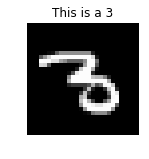

In [3]:
#exploring the training dataset
#typically you would clean up and transform dataset before trainin

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(2,10)

def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)
#calling 31st image from the training dataset
show_digit(train_set[0][30], 'This is a {}'.format(test_set[1][30]))

In [4]:
#transform the training dataset to upload it into S3
#transform from "numpy.array" to "RecordIO protobuf" format
#"fit" method for model training performs necesary transformation 


#training a model using high-level python lib from aws sagemaker
#choose the training algrorithm
#CreateTrainingjob

from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to : {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
               train_instance_count=2,
               train_instance_type='ml.c4.8xlarge',
               output_path=output_location,
               k=10,
               data_location=data_location)

training data will be uploaded to : s3://sagemaker-examples/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-examples/kmeans_example/output


In [5]:
%time
#start training model with "fit"
kmeans.fit(kmeans.record_set(train_set[0]))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


INFO:sagemaker:Creating training-job with name: kmeans-2017-12-20-21-45-13-127


.........................................................
Arguments: train
[12/20/2017 21:49:52 INFO 140279337944896 integration.py:222] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[12/20/2017 21:49:52 INFO 140279337944896 integration.py:228] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'500', u'k': u'10', u'force_dense': u'True'}
[12/20/2017 21:49:52 INFO 140279337944896

===== Job Complete =====


In [6]:
%time
#'sagemaker.amazon.kmeans.KMeans' provides deploy meathod for deploying model
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2017-12-20-21-54-29-465


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


INFO:sagemaker:Creating endpoint with name kmeans-2017-12-20-21-45-13-127


--------------------------------------------------------------------------------------------------------------------------------------------------------------!

In [7]:
#get inference for the 30th image in valid_set
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.289515495300293
    }
  }
}
]


In [8]:
%time
#get inference for first 100 images
result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs





Cluster 0:


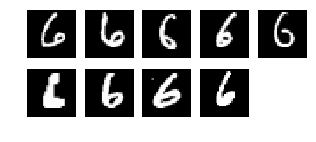




Cluster 1:


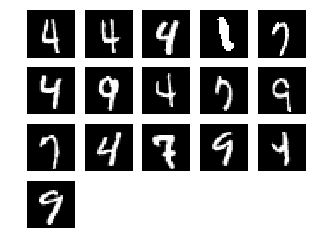




Cluster 2:


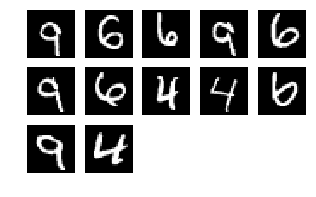




Cluster 3:


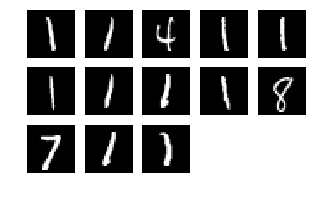




Cluster 4:


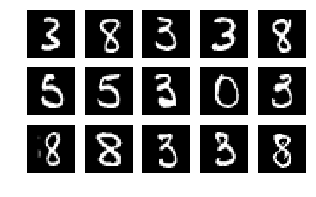




Cluster 5:


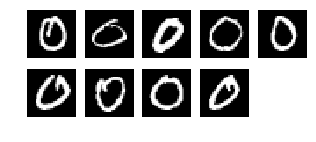




Cluster 6:


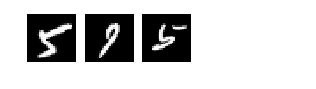




Cluster 7:


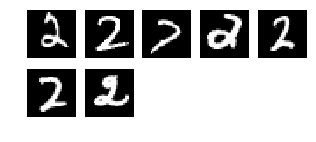




Cluster 8:


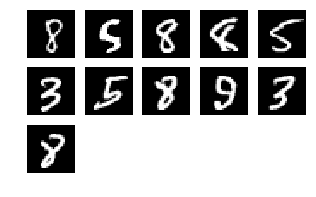




Cluster 9:


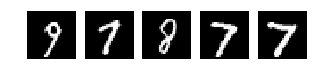

In [11]:
#visualize the results
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams['figure.figsize']=(width,height)
    _,subplots = plt.subplots(height,width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
        
    plt.show()